# Отчет по дисциплине «Machine learning and ANN»

### Задача классификации

**Тема исследования: «PTB_XL DataSet»** 

**Введение:** 

    Перед нами стоит задача классификации различных заболеваний сердца путем исследования ЭКГ человека. Классификацию необходимо производить посредстовом искуственных нейронных сетей. Зададимся целью провести ряд экспериментов с нейронными сетями, зафиксировать лучший результат и сравнить полученный результат с результатом работы стандартных методов машинного обучения при тех же входных данных.

**Ход работы:**

    Итак, начнем исследование. Для этого необходимо загрузить ряд библиотек для дальнейшей работы.

In [637]:
import pandas as pd
import numpy as np
import wfdb
import ast

In [638]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


    Загрузим данные и разделим их на тренировочный и тестовый наборы.

In [639]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = ''
sampling_rate=100

  #load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
#Y #pandas.dataframe

In [640]:
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [641]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic) 

# Split data into train and test
test_fold = 10
# Train

X_train_full = X[np.where(Y.strat_fold != test_fold)]
y_train_full = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

    Проанализируем наши метки (метками являются различные заболевания сердца и их комбинации):

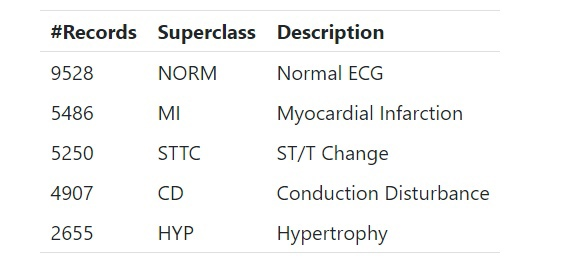


In [642]:
#размерность наших данных
X_train_full.shape

(19634, 1000, 12)

In [643]:
df_y = pd.Series(y_train_full)
print(df_y) 

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19634, dtype: object


    Наши классы и их количество:

In [644]:
df_y.value_counts()

[NORM]                 8170
[MI]                   2282
[STTC]                 2163
[CD]                   1525
[CD, MI]               1167
[STTC, HYP]             710
[STTC, MI]              541
[HYP]                   480
[CD, STTC]              434
[]                      367
[CD, NORM]              362
[HYP, STTC, MI]         318
[CD, HYP]               273
[CD, STTC, MI]          202
[CD, STTC, HYP]         186
[HYP, MI]               162
[HYP, STTC, CD, MI]      91
[CD, MI, HYP]            90
[CD, STTC, MI, HYP]      49
[STTC, NORM]             24
[HYP, CD, MI]            18
[CD, STTC, NORM]          5
[CD, HYP, MI]             4
[MI, HYP]                 4
[MI, STTC, HYP]           2
[MI, STTC, CD, HYP]       2
[HYP, NORM]               2
[CD, MI, HYP, NORM]       1
Name: diagnostic_superclass, dtype: int64

    Всего мы видим 26 различных классов (самые распространенные это Нормальное ЭКГ,инфаркт Миокарда и изменения ST/T) 

    Приведем данные в вид, пригодный для обучения:

In [645]:
y_test=y_test.values
y_train_full=y_train_full.values

    Удаялем пустые значения из тестовых и тренировочных данных:

In [646]:
a=[]
b=[]

y_train_full1=[]
for i in range(len(y_train_full)):
    if y_train_full[i] != list([]):
        y_train_full1.append(y_train_full[i])
    if y_train_full[i] == list([]):
        a.append(i)
        
y_test1=[]
for i in range(len(y_test)):
    if y_test[i] != list([]):
        y_test1.append(y_test[i])
    if y_test[i] == list([]):
        b.append(i)
        
y_train_full=np.array(y_train_full1)
a=np.array(a)
y_test=np.array(y_test1)
b=np.array(b)

<ipython-input-646-f8a0b744fccd>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_train_full=np.array(y_train_full1)
<ipython-input-646-f8a0b744fccd>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_test=np.array(y_test1)


In [647]:
X_train_full1=[]
for i in range(len(X_train_full)):
    if i in a:
        continue
    X_train_full1.append(X_train_full[i])
X_train_full=np.array(X_train_full1)

X_test1=[]
for i in range(len(X_test)):
    if i in b:
        continue
    X_test1.append(X_test[i])
X_test=np.array(X_test1)

In [648]:
#Проверям, размерность уменьшилась
y_test.shape

(2163,)

      Теперь необходимо распределить метки по суперклассам:

      Исходя из проведенного исследования, удалось сделать вывод, что название суперкласса, стоящего на 1 месте в множестве будет иметь бОльший вес относительно остальных в этом множестве. Именно поэтому распределение происходит исходя из экземпляра, стоящего на 1 месте в множестве (таким образм множества ['NORM','CD'] и ['CD','NORM'] - это разные множества)

In [649]:
#Преобразовываем метки класса
for i in range(len(y_test)):
    if 'NORM'== y_test[i][0]:
        y_test[i]='0'
    if 'CD'== y_test[i][0]: 
        y_test[i]='1'
    if 'MI'== y_test[i][0]: 
        y_test[i]='2'
    if 'STTC'== y_test[i][0]: 
        y_test[i]='3'
    if 'HYP'== y_test[i][0]: 
        y_test[i]='4'
for i in range(len(y_train_full)):
    if 'NORM'== y_train_full[i][0]:
        y_train_full[i]='0'
    if 'CD'== y_train_full[i][0]: 
        y_train_full[i]='1'
    if 'MI'== y_train_full[i][0]: 
        y_train_full[i]='2'
    if 'STTC'== y_train_full[i][0]: 
        y_train_full[i]='3'
    if 'HYP'== y_train_full[i][0]: 
        y_train_full[i]='4'

In [650]:
# Старое преобразование 
# for i in range(len(y_test)):
#     if y_test[i]== list(['NORM']):
#         y_test[i]='0'
#     if y_test[i]== list(['CD']) or y_test[i]==list(['NORM', 'CD']) or y_test[i]==list(['CD', 'NORM']) or y_test[i]==list(['NORM', 'CD', 'STTC']) or y_test[i]==list(['MI', 'STTC', 'CD', 'HYP']) or y_test[i]==list(['MI', 'NORM', 'CD', 'HYP']) or y_test[i]==list(['MI', 'HYP', 'CD'] ) or y_test[i]==list(['HYP', 'CD', 'STTC']) or y_test[i]==list(['MI', 'CD', 'STTC']) or y_test[i]==list(['CD', 'HYP']):
#         y_test[i]='1'
#     if y_test[i]== list(['MI']) or y_test[i]==list(['MI', 'HYP', 'CD', 'STTC']) or y_test[i]==list(['MI', 'CD', 'HYP']) or y_test[i]==list(['MI', 'STTC', 'CD']) or y_test[i]==list(['MI', 'HYP', 'STTC']) or y_test[i]==list(['MI', 'STTC']) or y_test[i]==list(['MI', 'CD']):
#         y_test[i]='2'
#     if y_test[i]== list(['STTC']) or y_test[i]==list(['NORM', 'STTC']) or y_test[i]==list(['STTC', 'HYP']) or y_test[i]==list(['STTC', 'CD']) or y_test[i]==list(['CD', 'STTC']) or  y_test[i]==list(['CD', 'STTC', 'HYP']):
#         y_test[i]='3'
#     if y_test[i]== list(['HYP']) or y_test[i]==list(['NORM', 'HYP']) or y_test[i]==list(['MI', 'STTC', 'HYP']) or y_test[i]==list(['STTC', 'CD', 'HYP']) or y_test[i]==list(['MI', 'CD', 'HYP', 'STTC']) or y_test[i]==list(['HYP', 'CD']) or y_test[i]==list(['CD', 'HYP', 'STTC']) or y_test[i]==list(['MI', 'HYP']) or y_test[i]==list(['HYP', 'STTC']) or y_test[i]==list(['NORM', 'CD', 'HYP']) or y_test[i]==list(['HYP', 'STTC', 'CD']):
#         y_test[i]='4'
# for i in range(len(y_train_full)):
#     if y_train_full[i]== list(['NORM']):
#         y_train_full[i]='0'
#     if y_train_full[i]== list(['CD']) or y_train_full[i]==list(['NORM', 'CD']) or y_train_full[i]==list(['CD', 'NORM']) or y_train_full[i]==list(['NORM', 'CD', 'STTC']) or y_train_full[i]==list(['MI', 'STTC', 'CD', 'HYP']) or y_train_full[i]==list(['MI', 'NORM', 'CD', 'HYP']) or y_train_full[i]==list(['MI', 'HYP', 'CD'] ) or y_train_full[i]==list(['HYP', 'CD', 'STTC']) or y_train_full[i]==list(['MI', 'CD', 'STTC']) or y_train_full[i]==list(['CD', 'HYP']):
#         y_train_full[i]='1'
#     if y_train_full[i]== list(['MI']) or y_train_full[i]==list(['MI', 'HYP', 'CD', 'STTC']) or y_train_full[i]==list(['MI', 'CD', 'HYP']) or y_train_full[i]==list(['MI', 'STTC', 'CD']) or y_train_full[i]==list(['MI', 'HYP', 'STTC']) or y_train_full[i]==list(['MI', 'STTC']) or y_train_full[i]==list(['MI', 'CD']):
#         y_train_full[i]='2'
#     if y_train_full[i]== list(['STTC']) or y_train_full[i]==list(['NORM', 'STTC']) or y_train_full[i]==list(['STTC', 'HYP']) or y_train_full[i]==list(['STTC', 'CD']) or y_train_full[i]==list(['CD', 'STTC']) or y_train_full[i]==list(['CD', 'STTC', 'HYP']):
#         y_train_full[i]='3'
#     if y_train_full[i]== list(['HYP']) or y_train_full[i]==list(['NORM', 'HYP']) or y_train_full[i]==list(['MI', 'STTC', 'HYP']) or y_train_full[i]==list(['STTC', 'CD', 'HYP']) or y_train_full[i]==list(['MI', 'CD', 'HYP', 'STTC']) or y_train_full[i]==list(['HYP', 'CD']) or y_train_full[i]==list(['CD', 'HYP', 'STTC']) or y_train_full[i]==list(['MI', 'HYP']) or y_train_full[i]==list(['HYP', 'STTC']) or y_train_full[i]==list(['NORM', 'CD', 'HYP']) or y_train_full[i]==list(['HYP', 'STTC', 'CD']) :
#         y_train_full[i]='4'

     Смотрим на новое распределение классов в тренировочном наборе:

In [651]:
df_y = pd.Series(y_train_full)
df_y.value_counts()

0    8170
1    4298
3    3438
2    2290
4    1071
dtype: int64

    Смотрим на новое распределение классов в тестовом наборе:

In [652]:
df_y = pd.Series(y_test)
df_y.value_counts()

0    913
1    487
3    381
2    257
4    125
dtype: int64

    Здесь узнаем количество наших классов (необходимо для выходного слоя)

In [653]:
from collections import Counter
cnt = Counter(y_train_full)
y_l=list(cnt.keys())
len(cnt.keys())

5

    Предподготовка данных посредством Encoder-ов:

##### LabelEncoder

In [654]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(y_test)
# y_test=le.transform(y_test)

# le = preprocessing.LabelEncoder()
# le.fit(y_train_full)
# y_train_full=le.transform(y_train_full)

#####  OneHotEncoder

In [655]:
from sklearn.preprocessing import OneHotEncoder
y_train_full= y_train_full.reshape(-1, 1)
onehotencoder = OneHotEncoder()
y_train_full= onehotencoder.fit_transform(y_train_full).toarray()

y_test= y_test.reshape(-1, 1)
onehotencoder = OneHotEncoder()
y_test= onehotencoder.fit_transform(y_test).toarray()


# import tensorflow as tf
# a = tf.keras.utils.to_categorical([0,1,2,3,4], num_classes=5)
# a = tf.constant(a, shape=[5,5])
# print(a)

# b = tf.keras.utils.to_categorical([0,1,2,3,4], num_classes=5)
# b = tf.constant(b, shape=[5, 5])
# print(b)


    Разделим полный обучающий набор на проверочный и (меньший) обучающий набор.

In [656]:
X_valid, X_train = X_train_full[:2000], X_train_full[2000:]
y_valid, y_train = y_train_full[:2000].astype(np.int32), y_train_full[2000:].astype(np.int32)

In [657]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [658]:
#Обучающий набор содержит 19634 примера, каждый размером 1000x12 dim (1d array = 12000):
X_train_full.shape

(19267, 1000, 12)

    Теперь построим первую проверочную нейронную сеть. Представлена классификация MLP с двумя скрытыми слоями:

# Creating the Model Using the Sequential API

In [659]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

    1. Первая строка создает последовательную модель.
    Это модель для нейронных сетей, которые состоят только из одного стека слоев, соединенных
    последовательно(последовательный API).
    2. Затем мы строим первый слой и добавляем его к модели. Это слой Flatten, его
    роль состоит в том, чтобы просто преобразовать каждое входное изображение в одномерный массив: если он получает входные данные
    X, он вычисляет X.reshape (-1, 1). Этот слой не имеет параметров, он
    просто там, чтобы выполнить простую предварительную обработку.
    3. Затем мы добавляем плотный скрытый слой с 300 нейронами. Он будет использовать функцию активации ReLU.
    4. Затем мы добавляем второй плотный скрытый слой  со 100 нейронами, также используя ReLU.
    5. В заключении, добавляем плотный выходной слой с 5 нейронами (по одному на класс), используя
    функция активации softmax (поскольку классы эксклюзивны).

In [660]:
#здесь два скрытых слоя (300 и 100 нейронов) и выходной слой в 26 нейронов (кол-во классов)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[1000, 12]),#тут надо проверить
    keras.layers.Dense(300, activation="relu"), #мб увеличить кол во нейронов
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

    Выведем список наших слоев

In [661]:
model.layers

    Посмотрим общую информацию о всех слоях:

    Метод summary () отображает все слои модели, их
    форму вывода и количество параметров.

    Сводка заканчивается общим количеством параметров, включая обучаемые и
    необучаемые параметры. Здесь у нас есть только обучаемые параметры

In [662]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12000)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               3600300   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 3,630,905
Trainable params: 3,630,905
Non-trainable params: 0
_________________________________________________________________


    Плотные слои (Dense) имеют множество параметров. Первый скрытый
    слой имеет 1000 × 12 весов , плюс 300 смещений(bias), что в сумме дает
    3 600 300  параметров.

    Это дает модели достаточно гибкости, чтобы соответствовать тренировкам
    данных, но это также означает, что модель подвержена риску переобучения, особенно когда
    нет большого количества обучающих данных.

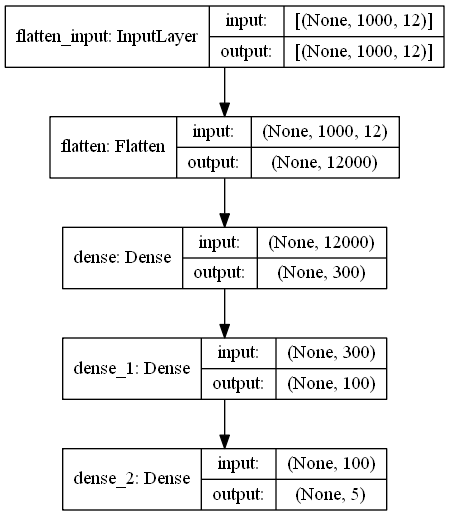

In [663]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

    Доступ ко всем параметрам слоя можно получить с помощью методов get_weights () и
    set_weights()

In [664]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
weights

array([[ 0.00726914, -0.00260589, -0.00649856, ..., -0.00821148,
         0.01145632, -0.02045234],
       [ 0.00141458, -0.00921885, -0.01741648, ...,  0.00179   ,
        -0.00820474, -0.0123656 ],
       [-0.01837395, -0.02048964,  0.02108453, ..., -0.01258184,
         0.02114145, -0.02176528],
       ...,
       [ 0.01143677,  0.01750243, -0.02063814, ..., -0.01442181,
         0.00550738, -0.01117877],
       [-0.01172718, -0.02131165, -0.01305801, ..., -0.00644325,
        -0.00272504,  0.01548625],
       [-0.0211114 , -0.01430395, -0.01064856, ..., -0.00696237,
         0.01351381, -0.01344387]], dtype=float32)

In [665]:
#количество всех весов
weights.shape

(12000, 300)

In [666]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

    Плотный слой (Dense) инициализирует веса соединения случайным образом, а смещения были просто инициализированы нулями.


In [667]:
biases.shape

(300,)

    Стоит заметить, что форма матрицы весов зависит от количества входов.

### Составление модели

    Используется метод compile (), чтобы указать функцию потерь и нужный оптимизатор. Также указывается показатель для 
    вычисления оценки обучения:

In [668]:
#loss="sparse_categorical_crossentropy" acc=0.99 val_acc=0.45
#loss="sparse_categorical_crossentropy", #используем эту кроссэентропию для 1d массива 

model.compile(loss="categorical_crossentropy", #используем эту кроссэентропию для 2d массива 
              optimizer = "sgd",
              metrics=["accuracy"]) #используем точность

     1. Стоит объяснить выбор функций. Сначала мы используем categorical_crossen
    tropy, потому что у нас есть метки, обработанные one_hot_encoder (sparse_categorical_crossen
    tropy используется если есть целостные метки)

      Если бы вместо этого у нас было
    одна целевая вероятность на класс для каждого экземпляра (например, hot_vectors, например [0.,
    0., 0., 1., 0.] для представления класса 3), тогда нам понадобится
    вместо этого использовать функцию потерь "categorical_crossentropy". 

      Если бы мы делали двоичную классификацию
    (с одной или несколькими двоичными метками), тогда будем использовать "sigmoid" с
    функцией активации logistic в выходном слое вместо функции активации softmax, и мы использовали бы функцию потерь  "binary_crossentropy".
    2. «sgd» просто означает, что обучение модели будет происходить,используя простой стохастический градиентный спуск. Другими словами, Керас выполнит алгоритм обратного распространения.
    3. Поскольку это классификатор, полезно измерять его "точность"(accuracy) во время обучения.

### Использование Callbacks во время обучения

        Метод fit () принимает аргумент Callback , который позволяет указать список объектов,
    что Керас будет вызывать во время тренировки в начале и в конце тренировки, эпохи и даже партии(batch).

        Более того, при использовании набора проверки во время обучения, установим
    save_best_only = True при создании ModelCheckpoint. В этом случае мы 
    сохраним модель, когда ее производительность на проверочном наборе будет лучшей. Это
    позволит не беспокоиться о переобучении модели, мы просто восстановим последнюю сохраненную после обучения модель, и это         будет лучшая модель на проверочном наборе. Это один из способов организовать (early stopping) раннюю остановку обучения.

In [669]:
#Using Callbacks during Training
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

        Теперь не нужно беспокоиться о переобучении тренировок set: просто восстановите последнюю модель, сохраненную после обучения, и это будет лучшая модель на проверочном наборе. Это простой способ реализовать раннюю остановку

        Ниже код для работы TensorBoard (о которой чуть ниже)

In [670]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

In [671]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_06_09-19_00_08'

### Тренировка и оценка модели

        Теперь модель готова к обучению. 
    
        Для обучения нужно вызвать метод fit(). Передаем ему входные функции (X_train) и целевые классы (y_train), а также количество эпох для обучения. Мы также передаем проверочный набор: keras будет измерять потери и дополнительные метрики для этого набора наконец каждой эпохи, что очень полезно, чтобы увидеть, насколько хорошо модель действительно работает: если производительность на обучающем наборе намного лучше, чем на проверочном наборе, модель, вероятно, переоценивает обучающий набор.

In [672]:
#from sklearn.utils import class_weight
#class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train_full),y_train_full)

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=15,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3), tensorboard_cb], #callbacks=[checkpoint_cb, tensorboard_cb],# rollback to best model # callbacks=[val_train_ratio_cb]
                    validation_data=(X_valid, y_valid))#,class_weight=class_weight)
#patience=3 кол-во эпох застоя

Epoch 1/15
540/540 [==============================] - 8s 14ms/step - loss: 1.4912 - accuracy: 0.3901 - val_loss: 1.3336 - val_accuracy: 0.5275
Epoch 2/15
540/540 [==============================] - 7s 13ms/step - loss: 1.3298 - accuracy: 0.4713 - val_loss: 1.2970 - val_accuracy: 0.5315
Epoch 3/15
540/540 [==============================] - 7s 13ms/step - loss: 1.2015 - accuracy: 0.5246 - val_loss: 1.2783 - val_accuracy: 0.5370
Epoch 4/15
540/540 [==============================] - 7s 13ms/step - loss: 1.0785 - accuracy: 0.5855 - val_loss: 1.2721 - val_accuracy: 0.5360
Epoch 5/15
540/540 [==============================] - 7s 13ms/step - loss: 0.9274 - accuracy: 0.6664 - val_loss: 1.2919 - val_accuracy: 0.5320
Epoch 6/15
540/540 [==============================] - 7s 13ms/step - loss: 0.7618 - accuracy: 0.7493 - val_loss: 1.3134 - val_accuracy: 0.5365
Epoch 7/15
540/540 [==============================] - 7s 13ms/step - loss: 0.5997 - accuracy: 0.8313 - val_loss: 1.3739 - val_accuracy: 0.5365

        Теперь нейронная сеть обучена. В каждую эпоху во время тренировки keras отображает
    количество обработанных экземпляров (вместе с индикатором выполнения), среднее
    время обучения на выборку, потери и точность, как на обучающем наборе, так и на проверочном наборе.

        В данном случае потери на тренировочном наборе 
    снижаются, что является хорошим признаком, а точность проверки достигла 48,71% после 7
    эпох. Это является плохим результатом, поэтому следует продолжить ислледование

#### TensorBoard 

        TensorBoard - это инструмент визуализации, который можно использовать для просмотра
    кривых обучения. Он позволяет сравнивать кривые обучения между несколькими запусками.

Чтобы запустить сервер TensorBoard, одним из вариантов является открытие терминала, при необходимости активируйте virtualenv, на котором вы установили TensorBoard, перейдите в каталог этого ноутбука, затем введите:

$ tensorboard --logdir =. / my_logs --port = 6006 Затем вы можете открыть свой веб-браузер по адресу localhost: 6006 и использовать TensorBoard. Когда вы закончите, нажмите Ctrl-C в окне терминала, это отключит сервер TensorBoard.

В качестве альтернативы вы можете загрузить расширение TensorBoard Jupyter и запустить его следующим образом:

In [749]:
 %load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11512), started 6 days, 4:05:17 ago. (Use '!kill 11512' to kill it.)

In [674]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [675]:
model = keras.models.load_model("my_keras_model.h5")

In [676]:
#Параметры нашего обучения
history.params

{'verbose': 1, 'epochs': 15, 'steps': 540}

        History возвращает объект с потерями и дополнительными метриками.
    Они измеряются в конце каждой эпохи на обучающем и на проверочном наборе. Создадим Pandas DataFrame словарь и с его помощью  получим кривые обучения.

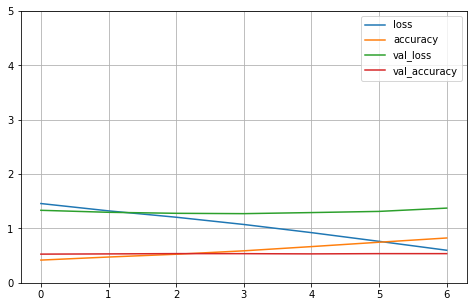

In [677]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

        Здесь отчетливо видно, что точность на тренировочном наборе возрастает вместе с количеством эпох, а потери наоборот убывают, это говорит о хорошей работе модели. Но! Точность на проверочном наборе не растет, а потери даже возрастают, это говорит о том, что нужно пересмотреть параметры системы. Скорее возникает случай переоснащения модели (overfitting) 

In [678]:
y_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [679]:
y_test1 = np.argmax(y_test,axis=-1)
y_test1

array([0, 0, 0, ..., 0, 1, 2], dtype=int64)

In [682]:
#оценим модель на тестовом наборе 
#model.evaluate(X_test,y_test)
model.evaluate(X_test,y_test1)

68/68 [==============================] - 2s 21ms/step - loss: 3.1805 - accuracy: 0.1877


[3.1805031299591064, 0.1877022683620453]

        Производительность модели не устраивает,следует настроить гиперпараметры модели, например количество слоев, 
    количество нейронов на слой, типы функций активации, которые мы используем для каждого скрытого слоя,
    количество эпох обучения, размер пакета(batch_size).

### Сохранение модели

    Сохранение обученной модели

In [683]:
model.save("my_keras_model.h5")

    Загрузка обученной модели

In [684]:
#model = keras.models.load_model("my_keras_model.h5") 

### Настройка Гиперпараметров

Ниже будет подобрано опитмальное количество
скрытых слоев, количество нейронов на слой и другие гиперпараметры.

Попробуем начать с поиска оптимальной функции опитимизации

**Первая модель**

Здесь попробуем другую функцию активации : "tanh"

In [706]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [707]:
#здесь два скрытых слоя (300 и 100 нейронов) и выходной слой в 26 нейронов (кол-во классов)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[1000, 12]),#тут надо проверить
    keras.layers.Dense(300, activation="tanh"), #мб увеличить кол во нейронов
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(5, activation="softmax")
])

In [708]:
#optimizer = keras.optimizers.Nadam(0.01)
#optimizer='adam'-попробовать
model.compile(loss="categorical_crossentropy", #используем эту кроссэентропию для 2d массива 
              optimizer = "sgd",
              metrics=["accuracy"]) #используем точность

In [709]:
history = model.fit(X_train, y_train, epochs=15,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3), tensorboard_cb], #callbacks=[checkpoint_cb, tensorboard_cb],# rollback to best model # callbacks=[val_train_ratio_cb]
                    validation_data=(X_valid, y_valid))#,class_weight=class_weight)
#patience=3 кол-во эпох застоя

Epoch 1/15
540/540 [==============================] - 20s 36ms/step - loss: 1.5421 - accuracy: 0.3408 - val_loss: 1.3632 - val_accuracy: 0.4975
Epoch 2/15
540/540 [==============================] - 7s 13ms/step - loss: 1.3672 - accuracy: 0.4426 - val_loss: 1.3751 - val_accuracy: 0.4965
Epoch 3/15
540/540 [==============================] - 7s 13ms/step - loss: 1.3083 - accuracy: 0.4714 - val_loss: 1.3969 - val_accuracy: 0.4790
Epoch 4/15
540/540 [==============================] - 6s 12ms/step - loss: 1.2780 - accuracy: 0.4833 - val_loss: 1.4119 - val_accuracy: 0.4705


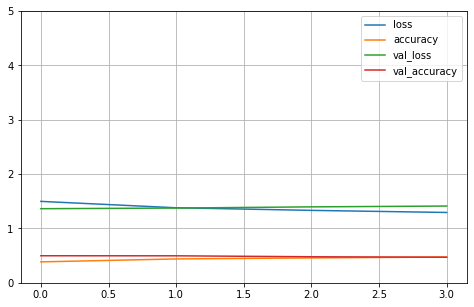

In [710]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

Вывод: точность оказалась ниже, чем у RELU

**Вторая модель**

Попробуем функцию активации LeakyRELU

In [712]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [713]:
#здесь два скрытых слоя (300 и 100 нейронов) и выходной слой в 26 нейронов (кол-во классов)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[1000, 12]),#тут надо проверить
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(5, activation="softmax")
])

In [714]:
#optimizer = keras.optimizers.Nadam(0.01)
#optimizer='adam'-попробовать
model.compile(loss="categorical_crossentropy", #используем эту кроссэентропию для 2d массива 
              optimizer = "sgd",
              metrics=["accuracy"]) #используем точность

In [715]:
history = model.fit(X_train, y_train, epochs=15,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3), tensorboard_cb], #callbacks=[checkpoint_cb, tensorboard_cb],# rollback to best model # callbacks=[val_train_ratio_cb]
                    validation_data=(X_valid, y_valid))#,class_weight=class_weight)
#patience=3 кол-во эпох застоя

Epoch 1/15
540/540 [==============================] - 8s 14ms/step - loss: 1.5026 - accuracy: 0.3908 - val_loss: 1.3625 - val_accuracy: 0.5165
Epoch 2/15
540/540 [==============================] - 7s 13ms/step - loss: 1.3337 - accuracy: 0.4695 - val_loss: 1.3431 - val_accuracy: 0.5185
Epoch 3/15
540/540 [==============================] - 7s 13ms/step - loss: 1.2256 - accuracy: 0.5157 - val_loss: 1.3385 - val_accuracy: 0.5155
Epoch 4/15
540/540 [==============================] - 7s 13ms/step - loss: 1.1409 - accuracy: 0.5594 - val_loss: 1.3353 - val_accuracy: 0.5140
Epoch 5/15
540/540 [==============================] - 7s 13ms/step - loss: 1.0369 - accuracy: 0.6128 - val_loss: 1.3489 - val_accuracy: 0.4935
Epoch 6/15
540/540 [==============================] - 7s 13ms/step - loss: 0.9336 - accuracy: 0.6627 - val_loss: 1.3598 - val_accuracy: 0.5060
Epoch 7/15
540/540 [==============================] - 7s 13ms/step - loss: 0.8235 - accuracy: 0.7195 - val_loss: 1.3886 - val_accuracy: 0.5040

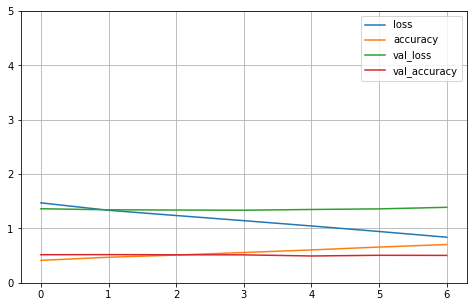

In [716]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

Вывод: видим, что картина примерно такая же, как у RELU, но RELU все же действует несколько лучше

**Третья модель**

Попробуем функцию активации LeakyRELU

In [717]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [718]:
#здесь два скрытых слоя (300 и 100 нейронов) и выходной слой в 26 нейронов (кол-во классов)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[1000, 12]),#тут надо проверить
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(5, activation="softmax")
])

In [719]:
#optimizer = keras.optimizers.Nadam(0.01)
#optimizer='adam'-попробовать
model.compile(loss="categorical_crossentropy", #используем эту кроссэентропию для 2d массива 
              optimizer = "sgd",
              metrics=["accuracy"]) #используем точность

In [720]:
history = model.fit(X_train, y_train, epochs=15,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3), tensorboard_cb], #callbacks=[checkpoint_cb, tensorboard_cb],# rollback to best model # callbacks=[val_train_ratio_cb]
                    validation_data=(X_valid, y_valid))#,class_weight=class_weight)
#patience=3 кол-во эпох застоя

Epoch 1/15
540/540 [==============================] - 8s 14ms/step - loss: 1.4875 - accuracy: 0.4078 - val_loss: 1.3519 - val_accuracy: 0.5265
Epoch 2/15
540/540 [==============================] - 7s 13ms/step - loss: 1.3188 - accuracy: 0.4784 - val_loss: 1.3167 - val_accuracy: 0.5310
Epoch 3/15
540/540 [==============================] - 7s 13ms/step - loss: 1.1806 - accuracy: 0.5364 - val_loss: 1.3018 - val_accuracy: 0.5340
Epoch 4/15
540/540 [==============================] - 7s 13ms/step - loss: 1.0478 - accuracy: 0.6058 - val_loss: 1.2909 - val_accuracy: 0.5300
Epoch 5/15
540/540 [==============================] - 7s 13ms/step - loss: 0.8830 - accuracy: 0.6960 - val_loss: 1.3120 - val_accuracy: 0.5140
Epoch 6/15
540/540 [==============================] - 7s 13ms/step - loss: 0.7154 - accuracy: 0.7830 - val_loss: 1.3233 - val_accuracy: 0.5250
Epoch 7/15
540/540 [==============================] - 7s 13ms/step - loss: 0.5466 - accuracy: 0.8575 - val_loss: 1.3877 - val_accuracy: 0.5250

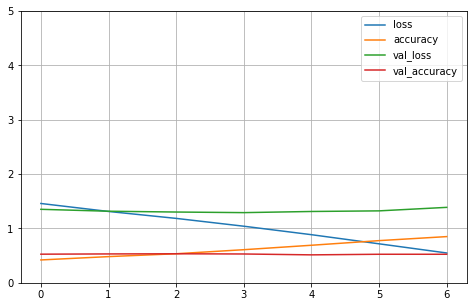

In [721]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

Вывод: Точность на проверочно наборе выше, чем у RELU, поэтому есть смысл использовать LeakyRELU

#### Batch Normalization

Пакетная нормализация (BN) применяется для решения проблем исчезающих / увеличивающихся градиентов.
Техника состоит в добавлении операции bn в модель непосредственно перед или после
функция активации каждого скрытого слоя, просто центрируя ноль и нормализуя каждый
вход

In [723]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [724]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[1000, 12]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])

In [725]:
#optimizer = keras.optimizers.Nadam(0.01)
model.compile(loss="categorical_crossentropy", #используем эту кроссэентропию для 2d массива 
              optimizer = "sgd",
              metrics=["accuracy"]) #используем точность

In [726]:
history = model.fit(X_train, y_train, epochs=15,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3), tensorboard_cb], #callbacks=[checkpoint_cb, tensorboard_cb],# rollback to best model # callbacks=[val_train_ratio_cb]
                    validation_data=(X_valid, y_valid))#,class_weight=class_weight)
#patience=3 кол-во эпох застоя

Epoch 1/15
540/540 [==============================] - 12s 21ms/step - loss: 1.7087 - accuracy: 0.3383 - val_loss: 1.3198 - val_accuracy: 0.5105
Epoch 2/15
540/540 [==============================] - 10s 19ms/step - loss: 0.9869 - accuracy: 0.6337 - val_loss: 1.3296 - val_accuracy: 0.5210
Epoch 3/15
540/540 [==============================] - 10s 19ms/step - loss: 0.7419 - accuracy: 0.7464 - val_loss: 1.4011 - val_accuracy: 0.5105
Epoch 4/15
540/540 [==============================] - 10s 19ms/step - loss: 0.5738 - accuracy: 0.8168 - val_loss: 1.4731 - val_accuracy: 0.4885


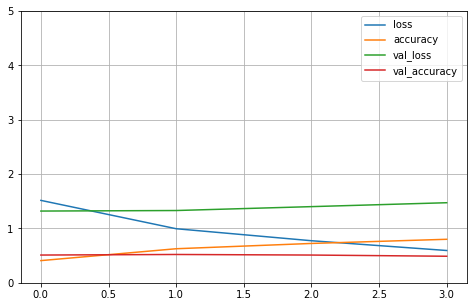

In [727]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

Вывод: Модель начала переобучаться, поэтому сработала ранняя остановка. Точность снизилась, как на обучающем наборе, так и на проверочном.

##### **Теперь попробуем различные функции оптимизации:**

In [734]:
[m for m in dir(keras.optimizers) if not m.startswith("_")]

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'Ftrl',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 'deserialize',
 'get',
 'schedules',
 'serialize']

**1 модель**

In [728]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [729]:
#здесь два скрытых слоя (300 и 100 нейронов) и выходной слой в 26 нейронов (кол-во классов)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[1000, 12]),#тут надо проверить
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(5, activation="softmax")
])

In [730]:
#optimizer = keras.optimizers.Nadam(0.01)
model.compile(loss="categorical_crossentropy", #используем эту кроссэентропию для 2d массива 
              optimizer='adam',
              metrics=["accuracy"]) #используем точность

In [731]:
history = model.fit(X_train, y_train, epochs=15,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3), tensorboard_cb], #callbacks=[checkpoint_cb, tensorboard_cb],# rollback to best model # callbacks=[val_train_ratio_cb]
                    validation_data=(X_valid, y_valid))#,class_weight=class_weight)
#patience=3 кол-во эпох застоя

Epoch 1/15
540/540 [==============================] - 12s 22ms/step - loss: 1.4921 - accuracy: 0.4116 - val_loss: 1.2871 - val_accuracy: 0.5260
Epoch 2/15
540/540 [==============================] - 11s 21ms/step - loss: 1.0865 - accuracy: 0.6015 - val_loss: 1.3686 - val_accuracy: 0.5260
Epoch 3/15
540/540 [==============================] - 11s 21ms/step - loss: 0.7038 - accuracy: 0.7610 - val_loss: 1.6740 - val_accuracy: 0.4845
Epoch 4/15
540/540 [==============================] - 11s 21ms/step - loss: 0.3883 - accuracy: 0.8896 - val_loss: 1.9925 - val_accuracy: 0.4595


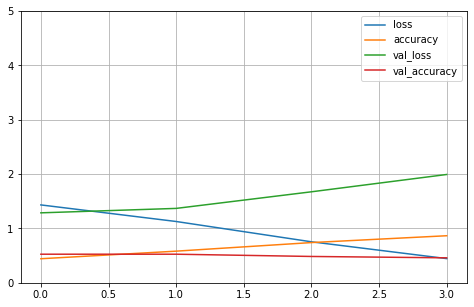

In [732]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

Вывод: Функция активации adam приводит к плохим результатам

**2 модель**

Попробуем оптимизатор на основе стохастического градиентного спуска с заданной скоростью обучения и  с нестеровским моментом

In [737]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [738]:
#здесь два скрытых слоя (300 и 100 нейронов) и выходной слой в 26 нейронов (кол-во классов)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[1000, 12]),#тут надо проверить
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(5, activation="softmax")
])

In [739]:

myOpt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.0, nesterov=True)
model.compile(loss="categorical_crossentropy", #используем эту кроссэентропию для 2d массива 
              optimizer=myOpt,
              metrics=["accuracy"]) #используем точность

In [740]:
history = model.fit(X_train, y_train, epochs=15,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3), tensorboard_cb], #callbacks=[checkpoint_cb, tensorboard_cb],# rollback to best model # callbacks=[val_train_ratio_cb]
                    validation_data=(X_valid, y_valid))#,class_weight=class_weight)
#patience=3 кол-во эпох застоя

Epoch 1/15
540/540 [==============================] - 7s 13ms/step - loss: 1.4402 - accuracy: 0.4328 - val_loss: 1.2536 - val_accuracy: 0.5265
Epoch 2/15
540/540 [==============================] - 7s 12ms/step - loss: 1.0566 - accuracy: 0.5997 - val_loss: 1.3459 - val_accuracy: 0.5125
Epoch 3/15
540/540 [==============================] - 7s 13ms/step - loss: 1.2270 - accuracy: 0.7250 - val_loss: 2.0028 - val_accuracy: 0.5305
Epoch 4/15
540/540 [==============================] - 7s 12ms/step - loss: nan - accuracy: 0.6754 - val_loss: nan - val_accuracy: 0.5150


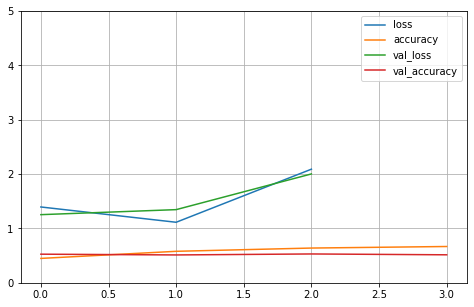

In [741]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

Вывод: видно, что нестеровский момент только усугубил ситуацию

**3 модель**

Посмотрим на оптимизатор "Ftrl"

In [743]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [744]:
#здесь два скрытых слоя (300 и 100 нейронов) и выходной слой в 26 нейронов (кол-во классов)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[1000, 12]),#тут надо проверить
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(5, activation="softmax")
])

In [745]:
model.compile(loss="categorical_crossentropy", #используем эту кроссэентропию для 2d массива 
              optimizer="Ftrl",
              metrics=["accuracy"]) #используем точность

In [746]:
history = model.fit(X_train, y_train, epochs=15,
                    callbacks=[keras.callbacks.EarlyStopping(patience=3), tensorboard_cb], #callbacks=[checkpoint_cb, tensorboard_cb],# rollback to best model # callbacks=[val_train_ratio_cb]
                    validation_data=(X_valid, y_valid))#,class_weight=class_weight)
#patience=3 кол-во эпох застоя

Epoch 1/15
540/540 [==============================] - 14s 24ms/step - loss: 1.6009 - accuracy: 0.4131 - val_loss: 1.5865 - val_accuracy: 0.5150
Epoch 2/15
540/540 [==============================] - 12s 22ms/step - loss: 1.5906 - accuracy: 0.4097 - val_loss: 1.5765 - val_accuracy: 0.5150
Epoch 3/15
540/540 [==============================] - 12s 23ms/step - loss: 1.5833 - accuracy: 0.4196 - val_loss: 1.5690 - val_accuracy: 0.5150
Epoch 4/15
540/540 [==============================] - 12s 23ms/step - loss: 1.5786 - accuracy: 0.4139 - val_loss: 1.5625 - val_accuracy: 0.5150
Epoch 5/15
540/540 [==============================] - 12s 23ms/step - loss: 1.5741 - accuracy: 0.4119 - val_loss: 1.5564 - val_accuracy: 0.5150
Epoch 6/15
540/540 [==============================] - 13s 23ms/step - loss: 1.5699 - accuracy: 0.4126 - val_loss: 1.5503 - val_accuracy: 0.5150
Epoch 7/15
540/540 [==============================] - 12s 23ms/step - loss: 1.5650 - accuracy: 0.4170 - val_loss: 1.5436 - val_accuracy:

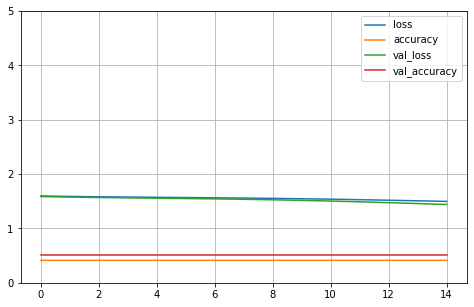

In [747]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

Вывод: лучшим вариантом для нас является обыкновенный стохастический градиентный спуск.

In [748]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Создание функции ,которая построит и скомпилирует модель Keras, учитывая набор гиперпараметров

In [689]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[1000, 12]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[1000, 12]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(len(cnt.keys()), activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [690]:
keras_Class = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [692]:
keras_Class.fit(X_train, y_train, epochs=15,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/15
540/540 [==============================] - 2s 3ms/step - loss: 1.5519 - accuracy: 0.3678 - val_loss: 1.4116 - val_accuracy: 0.5050
Epoch 2/15
540/540 [==============================] - 1s 3ms/step - loss: 1.4456 - accuracy: 0.4237 - val_loss: 1.3726 - val_accuracy: 0.5150
Epoch 3/15
540/540 [==============================] - 1s 3ms/step - loss: 1.3803 - accuracy: 0.4449 - val_loss: 1.3551 - val_accuracy: 0.5170
Epoch 4/15
540/540 [==============================] - 1s 3ms/step - loss: 1.3511 - accuracy: 0.4542 - val_loss: 1.3432 - val_accuracy: 0.5215
Epoch 5/15
540/540 [==============================] - 1s 3ms/step - loss: 1.3183 - accuracy: 0.4641 - val_loss: 1.3362 - val_accuracy: 0.5205
Epoch 6/15
540/540 [==============================] - 1s 3ms/step - loss: 1.2893 - accuracy: 0.4794 - val_loss: 1.3310 - val_accuracy: 0.5230
Epoch 7/15
540/540 [==============================] - 1s 3ms/step - loss: 1.2594 - accuracy: 0.4987 - val_loss: 1.3268 - val_accuracy: 0.5240
Epoch 

In [693]:
mse_test = keras_Class.score(X_test, y_test)

68/68 [==============================] - 0s 1ms/step - loss: 1.3890 - accuracy: 0.4554


In [694]:
X_new = X_test[:3]
y_pred = keras_Class.predict(X_new)
y_pred

C:\ANACONDA\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0])

  
    Нам необходимо обучить несколько вариантов и посмотреть, какой из них лучше всего работает. 
    Поскольку существует много гиперпараметров, предпочтительнее использовать рандомизированный поиск.
    Изучим число скрытых слоев, количество нейронов и скорость обучения:

In [695]:
np.random.seed(42)
tf.random.set_seed(42)

In [696]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_Class, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=4, n_hidden=1, learning_rate=0.022174573948353458 .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
360/360 [==============================] - 1s 3ms/step - loss: 1.5431 - accuracy: 0.3631 - val_loss: 1.3681 - val_accuracy: 0.5165
Epoch 2/100
360/360 [==============================] - 1s 2ms/step - loss: 1.4075 - accuracy: 0.4137 - val_loss: 1.3521 - val_accuracy: 0.5155
Epoch 3/100
360/360 [==============================] - 1s 2ms/step - loss: 1.3476 - accuracy: 0.4388 - val_loss: 1.3690 - val_accuracy: 0.5055
Epoch 4/100
360/360 [==============================] - 1s 2ms/step - loss: 1.3102 - accuracy: 0.4514 - val_loss: 1.3946 - val_accuracy: 0.4910
Epoch 5/100
360/360 [==============================] - 1s 2ms/step - loss: 1.2813 - accuracy: 0.4622 - val_loss: 1.4084 - val_accuracy: 0.4775
Epoch 6/100
360/360 [==============================] - 1s 2ms/step - loss: 1.2318 - accuracy: 0.4794 - val_loss: 1.4488 - val_accuracy: 0.4785
Epoch 7/100
360/360 [==============================] - 1s 2ms/step - loss: 1.2141 - accuracy: 0.4873 - val_loss: 1.4638 - val_accuracy: 0.4760

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


Epoch 1/100
360/360 [==============================] - 2s 4ms/step - loss: 1.5438 - accuracy: 0.3598 - val_loss: 1.3579 - val_accuracy: 0.5145
Epoch 2/100
360/360 [==============================] - 1s 3ms/step - loss: 1.4026 - accuracy: 0.4331 - val_loss: 1.3408 - val_accuracy: 0.5160
Epoch 3/100
360/360 [==============================] - 1s 3ms/step - loss: 1.3472 - accuracy: 0.4578 - val_loss: 1.3437 - val_accuracy: 0.5145
Epoch 4/100
360/360 [==============================] - 1s 3ms/step - loss: 1.3149 - accuracy: 0.4737 - val_loss: 1.3516 - val_accuracy: 0.5120
Epoch 5/100
360/360 [==============================] - 1s 2ms/step - loss: 1.2984 - accuracy: 0.4751 - val_loss: 1.3770 - val_accuracy: 0.5115
Epoch 6/100
360/360 [==============================] - 1s 2ms/step - loss: 1.2490 - accuracy: 0.4936 - val_loss: 1.3785 - val_accuracy: 0.5070
Epoch 7/100
360/360 [==============================] - 1s 2ms/step - loss: 1.2197 - accuracy: 0.5029 - val_loss: 1.4052 - val_accuracy: 0.4995

360/360 [==============================] - 2s 5ms/step - loss: 0.8912 - accuracy: 0.6842 - val_loss: 1.3374 - val_accuracy: 0.5220
Epoch 12/100
360/360 [==============================] - 2s 6ms/step - loss: 0.8199 - accuracy: 0.7208 - val_loss: 1.3496 - val_accuracy: 0.5205
Epoch 13/100
360/360 [==============================] - 2s 5ms/step - loss: 0.7524 - accuracy: 0.7562 - val_loss: 1.3772 - val_accuracy: 0.5205
Epoch 14/100
360/360 [==============================] - 2s 5ms/step - loss: 0.6677 - accuracy: 0.7922 - val_loss: 1.4084 - val_accuracy: 0.5040
Epoch 15/100
360/360 [==============================] - 2s 5ms/step - loss: 0.5971 - accuracy: 0.8298 - val_loss: 1.4390 - val_accuracy: 0.5100
Epoch 16/100
360/360 [==============================] - 2s 5ms/step - loss: 0.5265 - accuracy: 0.8613 - val_loss: 1.4823 - val_accuracy: 0.5020
Epoch 17/100
180/180 [==============================] - 0s 2ms/step - loss: 1.5893 - accuracy: 0.4441
[CV]  n_neurons=94, n_hidden=2, learning_rate=0

Epoch 30/100
360/360 [==============================] - 1s 4ms/step - loss: 1.3509 - accuracy: 0.4540 - val_loss: 1.3670 - val_accuracy: 0.5175
Epoch 31/100
360/360 [==============================] - 1s 3ms/step - loss: 1.3490 - accuracy: 0.4509 - val_loss: 1.3653 - val_accuracy: 0.5175
Epoch 32/100
360/360 [==============================] - 1s 4ms/step - loss: 1.3449 - accuracy: 0.4522 - val_loss: 1.3637 - val_accuracy: 0.5190
Epoch 33/100
360/360 [==============================] - 1s 3ms/step - loss: 1.3319 - accuracy: 0.4652 - val_loss: 1.3622 - val_accuracy: 0.5205
Epoch 34/100
360/360 [==============================] - 1s 3ms/step - loss: 1.3346 - accuracy: 0.4551 - val_loss: 1.3607 - val_accuracy: 0.5205
Epoch 35/100
360/360 [==============================] - 1s 3ms/step - loss: 1.3265 - accuracy: 0.4609 - val_loss: 1.3594 - val_accuracy: 0.5210
Epoch 36/100
360/360 [==============================] - 1s 3ms/step - loss: 1.3326 - accuracy: 0.4532 - val_loss: 1.3582 - val_accuracy:

Epoch 87/100
360/360 [==============================] - 1s 3ms/step - loss: 1.1574 - accuracy: 0.5432 - val_loss: 1.3385 - val_accuracy: 0.5200
Epoch 88/100
360/360 [==============================] - 1s 3ms/step - loss: 1.1482 - accuracy: 0.5464 - val_loss: 1.3385 - val_accuracy: 0.5205
Epoch 89/100
360/360 [==============================] - 1s 3ms/step - loss: 1.1452 - accuracy: 0.5514 - val_loss: 1.3385 - val_accuracy: 0.5200
Epoch 90/100
360/360 [==============================] - 1s 3ms/step - loss: 1.1504 - accuracy: 0.5456 - val_loss: 1.3385 - val_accuracy: 0.5180
Epoch 91/100
360/360 [==============================] - 1s 3ms/step - loss: 1.1514 - accuracy: 0.5480 - val_loss: 1.3385 - val_accuracy: 0.5180
Epoch 92/100
360/360 [==============================] - 1s 3ms/step - loss: 1.1446 - accuracy: 0.5503 - val_loss: 1.3385 - val_accuracy: 0.5170
Epoch 93/100
360/360 [==============================] - 1s 3ms/step - loss: 1.1380 - accuracy: 0.5535 - val_loss: 1.3385 - val_accuracy:

360/360 [==============================] - 1s 4ms/step - loss: 1.2853 - accuracy: 0.4907 - val_loss: 1.3498 - val_accuracy: 0.5185
Epoch 43/100
360/360 [==============================] - 1s 3ms/step - loss: 1.2833 - accuracy: 0.4872 - val_loss: 1.3489 - val_accuracy: 0.5185
Epoch 44/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2796 - accuracy: 0.4901 - val_loss: 1.3481 - val_accuracy: 0.5185
Epoch 45/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2740 - accuracy: 0.4917 - val_loss: 1.3474 - val_accuracy: 0.5185
Epoch 46/100
360/360 [==============================] - 2s 4ms/step - loss: 1.2763 - accuracy: 0.4887 - val_loss: 1.3466 - val_accuracy: 0.5180
Epoch 47/100
360/360 [==============================] - 2s 4ms/step - loss: 1.2674 - accuracy: 0.4956 - val_loss: 1.3459 - val_accuracy: 0.5180
Epoch 48/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2612 - accuracy: 0.5020 - val_loss: 1.3453 - val_accuracy: 0.5180
Epoch

Epoch 99/100
360/360 [==============================] - 1s 4ms/step - loss: 1.1058 - accuracy: 0.5841 - val_loss: 1.3353 - val_accuracy: 0.5175
Epoch 100/100
180/180 [==============================] - 0s 2ms/step - loss: 1.4265 - accuracy: 0.4460
[CV]  n_neurons=51, n_hidden=1, learning_rate=0.00037078874137762145, total= 2.3min
[CV] n_neurons=51, n_hidden=1, learning_rate=0.00037078874137762145 ..
Epoch 1/100
360/360 [==============================] - 2s 4ms/step - loss: 1.6319 - accuracy: 0.1929 - val_loss: 1.6138 - val_accuracy: 0.2360
Epoch 2/100
360/360 [==============================] - 1s 4ms/step - loss: 1.6010 - accuracy: 0.2538 - val_loss: 1.5830 - val_accuracy: 0.2985
Epoch 3/100
360/360 [==============================] - 1s 4ms/step - loss: 1.5729 - accuracy: 0.3047 - val_loss: 1.5562 - val_accuracy: 0.3430
Epoch 4/100
360/360 [==============================] - 1s 4ms/step - loss: 1.5499 - accuracy: 0.3443 - val_loss: 1.5328 - val_accuracy: 0.3825
Epoch 5/100
360/360 [=====

360/360 [==============================] - 1s 4ms/step - loss: 1.2339 - accuracy: 0.5005 - val_loss: 1.3283 - val_accuracy: 0.5190
Epoch 55/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2232 - accuracy: 0.5066 - val_loss: 1.3278 - val_accuracy: 0.5190
Epoch 56/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2283 - accuracy: 0.5038 - val_loss: 1.3273 - val_accuracy: 0.5185
Epoch 57/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2158 - accuracy: 0.5118 - val_loss: 1.3268 - val_accuracy: 0.5185
Epoch 58/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2180 - accuracy: 0.5087 - val_loss: 1.3263 - val_accuracy: 0.5180
Epoch 59/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2206 - accuracy: 0.5072 - val_loss: 1.3259 - val_accuracy: 0.5190
Epoch 60/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2113 - accuracy: 0.5120 - val_loss: 1.3255 - val_accuracy: 0.5195
Epoch

360/360 [==============================] - 2s 4ms/step - loss: 1.3777 - accuracy: 0.4333 - val_loss: 1.3426 - val_accuracy: 0.5215
Epoch 10/100
360/360 [==============================] - 2s 4ms/step - loss: 1.3559 - accuracy: 0.4479 - val_loss: 1.3393 - val_accuracy: 0.5215
Epoch 11/100
360/360 [==============================] - 2s 4ms/step - loss: 1.3479 - accuracy: 0.4489 - val_loss: 1.3356 - val_accuracy: 0.5230
Epoch 12/100
360/360 [==============================] - 2s 5ms/step - loss: 1.3383 - accuracy: 0.4533 - val_loss: 1.3329 - val_accuracy: 0.5270
Epoch 13/100
360/360 [==============================] - 2s 4ms/step - loss: 1.3249 - accuracy: 0.4581 - val_loss: 1.3299 - val_accuracy: 0.5255
Epoch 14/100
360/360 [==============================] - 2s 4ms/step - loss: 1.3182 - accuracy: 0.4621 - val_loss: 1.3273 - val_accuracy: 0.5270
Epoch 15/100
360/360 [==============================] - 2s 4ms/step - loss: 1.3028 - accuracy: 0.4706 - val_loss: 1.3248 - val_accuracy: 0.5300
Epoch

360/360 [==============================] - 2s 5ms/step - loss: 1.0818 - accuracy: 0.5748 - val_loss: 1.3073 - val_accuracy: 0.5170
Epoch 29/100
360/360 [==============================] - 2s 4ms/step - loss: 1.0508 - accuracy: 0.5970 - val_loss: 1.3078 - val_accuracy: 0.5150
Epoch 30/100
360/360 [==============================] - 2s 5ms/step - loss: 1.0331 - accuracy: 0.5989 - val_loss: 1.3083 - val_accuracy: 0.5120
Epoch 31/100
360/360 [==============================] - 2s 5ms/step - loss: 1.0031 - accuracy: 0.6208 - val_loss: 1.3123 - val_accuracy: 0.5110
Epoch 32/100
360/360 [==============================] - 2s 4ms/step - loss: 0.9798 - accuracy: 0.6375 - val_loss: 1.3117 - val_accuracy: 0.5125
Epoch 33/100
360/360 [==============================] - 2s 4ms/step - loss: 0.9595 - accuracy: 0.6453 - val_loss: 1.3149 - val_accuracy: 0.5085
Epoch 34/100
360/360 [==============================] - 2s 4ms/step - loss: 0.9347 - accuracy: 0.6612 - val_loss: 1.3168 - val_accuracy: 0.5025
Epoch

Epoch 8/100
360/360 [==============================] - 1s 2ms/step - loss: 1.1845 - accuracy: 0.5167 - val_loss: 1.5616 - val_accuracy: 0.4255
Epoch 9/100
360/360 [==============================] - 1s 2ms/step - loss: 1.1618 - accuracy: 0.5323 - val_loss: 1.5748 - val_accuracy: 0.4235
Epoch 10/100
360/360 [==============================] - 1s 2ms/step - loss: 1.1476 - accuracy: 0.5475 - val_loss: 1.5918 - val_accuracy: 0.4225
Epoch 11/100
180/180 [==============================] - 0s 1ms/step - loss: 1.6503 - accuracy: 0.3756
[CV]  n_neurons=40, n_hidden=0, learning_rate=0.01824796188192035, total=  10.0s
[CV] n_neurons=40, n_hidden=0, learning_rate=0.01824796188192035 .....
Epoch 1/100
360/360 [==============================] - 1s 3ms/step - loss: 1.5895 - accuracy: 0.2938 - val_loss: 1.4336 - val_accuracy: 0.4715
Epoch 2/100
360/360 [==============================] - 1s 2ms/step - loss: 1.3835 - accuracy: 0.4421 - val_loss: 1.4302 - val_accuracy: 0.4620
Epoch 3/100
360/360 [=========

360/360 [==============================] - 1s 3ms/step - loss: 1.3485 - accuracy: 0.4477 - val_loss: 1.3128 - val_accuracy: 0.5185
Epoch 7/100
360/360 [==============================] - 1s 3ms/step - loss: 1.3237 - accuracy: 0.4668 - val_loss: 1.3050 - val_accuracy: 0.5225
Epoch 8/100
360/360 [==============================] - 1s 3ms/step - loss: 1.2858 - accuracy: 0.4875 - val_loss: 1.3035 - val_accuracy: 0.5155
Epoch 9/100
360/360 [==============================] - 1s 3ms/step - loss: 1.2401 - accuracy: 0.5230 - val_loss: 1.2995 - val_accuracy: 0.5160
Epoch 10/100
360/360 [==============================] - 1s 3ms/step - loss: 1.1811 - accuracy: 0.5491 - val_loss: 1.3018 - val_accuracy: 0.5125
Epoch 11/100
360/360 [==============================] - 1s 3ms/step - loss: 1.1375 - accuracy: 0.5716 - val_loss: 1.3112 - val_accuracy: 0.5105
Epoch 12/100
360/360 [==============================] - 1s 3ms/step - loss: 1.0923 - accuracy: 0.5953 - val_loss: 1.3199 - val_accuracy: 0.5175
Epoch 13

Epoch 20/100
360/360 [==============================] - 1s 4ms/step - loss: 1.1049 - accuracy: 0.5789 - val_loss: 1.3471 - val_accuracy: 0.4955
Epoch 21/100
360/360 [==============================] - 1s 4ms/step - loss: 1.0886 - accuracy: 0.5934 - val_loss: 1.3486 - val_accuracy: 0.4925
Epoch 22/100
360/360 [==============================] - 1s 4ms/step - loss: 1.0758 - accuracy: 0.5995 - val_loss: 1.3494 - val_accuracy: 0.4925
Epoch 23/100
360/360 [==============================] - 1s 4ms/step - loss: 1.0549 - accuracy: 0.6084 - val_loss: 1.3508 - val_accuracy: 0.4930
Epoch 24/100
360/360 [==============================] - 1s 4ms/step - loss: 1.0455 - accuracy: 0.6168 - val_loss: 1.3516 - val_accuracy: 0.4925
Epoch 25/100
180/180 [==============================] - 0s 2ms/step - loss: 1.4075 - accuracy: 0.4580
[CV]  n_neurons=49, n_hidden=1, learning_rate=0.0020587676114196545, total=  33.5s
[CV] n_neurons=49, n_hidden=1, learning_rate=0.0020587676114196545 ...
Epoch 1/100
360/360 [===

360/360 [==============================] - 1s 4ms/step - loss: 1.0312 - accuracy: 0.6102 - val_loss: 1.3025 - val_accuracy: 0.5255
Epoch 23/100
360/360 [==============================] - 1s 4ms/step - loss: 1.0112 - accuracy: 0.6240 - val_loss: 1.3031 - val_accuracy: 0.5250
Epoch 24/100
360/360 [==============================] - 2s 4ms/step - loss: 0.9958 - accuracy: 0.6373 - val_loss: 1.3039 - val_accuracy: 0.5260
Epoch 25/100
360/360 [==============================] - 1s 4ms/step - loss: 0.9752 - accuracy: 0.6455 - val_loss: 1.3044 - val_accuracy: 0.5285
Epoch 26/100
360/360 [==============================] - 1s 4ms/step - loss: 0.9599 - accuracy: 0.6562 - val_loss: 1.3066 - val_accuracy: 0.5285
Epoch 27/100
360/360 [==============================] - 1s 4ms/step - loss: 0.9450 - accuracy: 0.6625 - val_loss: 1.3064 - val_accuracy: 0.5245
Epoch 28/100
360/360 [==============================] - 1s 4ms/step - loss: 0.9304 - accuracy: 0.6721 - val_loss: 1.3082 - val_accuracy: 0.5280
Epoch

360/360 [==============================] - 2s 5ms/step - loss: 0.9638 - accuracy: 0.6451 - val_loss: 1.3267 - val_accuracy: 0.5105
Epoch 10/100
360/360 [==============================] - 2s 6ms/step - loss: 0.8501 - accuracy: 0.6986 - val_loss: 1.3779 - val_accuracy: 0.5000
Epoch 11/100
360/360 [==============================] - 2s 5ms/step - loss: 0.7308 - accuracy: 0.7518 - val_loss: 1.4322 - val_accuracy: 0.5070
Epoch 12/100
360/360 [==============================] - 2s 5ms/step - loss: 0.6216 - accuracy: 0.7988 - val_loss: 1.5438 - val_accuracy: 0.4905
Epoch 13/100
360/360 [==============================] - 2s 5ms/step - loss: 0.5204 - accuracy: 0.8417 - val_loss: 1.6335 - val_accuracy: 0.4910
Epoch 14/100
360/360 [==============================] - 2s 5ms/step - loss: 0.4202 - accuracy: 0.8877 - val_loss: 1.7641 - val_accuracy: 0.4845
Epoch 15/100
360/360 [==============================] - 2s 5ms/step - loss: 0.3358 - accuracy: 0.9238 - val_loss: 1.9135 - val_accuracy: 0.4775
Epoch

360/360 [==============================] - 2s 5ms/step - loss: 1.0267 - accuracy: 0.6126 - val_loss: 1.3308 - val_accuracy: 0.5065
Epoch 10/100
360/360 [==============================] - 2s 5ms/step - loss: 0.9249 - accuracy: 0.6717 - val_loss: 1.3612 - val_accuracy: 0.4975
Epoch 11/100
360/360 [==============================] - 2s 5ms/step - loss: 0.8159 - accuracy: 0.7172 - val_loss: 1.3909 - val_accuracy: 0.5055
Epoch 12/100
360/360 [==============================] - 2s 5ms/step - loss: 0.6976 - accuracy: 0.7706 - val_loss: 1.4745 - val_accuracy: 0.4835
Epoch 13/100
360/360 [==============================] - 2s 5ms/step - loss: 0.5882 - accuracy: 0.8224 - val_loss: 1.5545 - val_accuracy: 0.4850
Epoch 14/100
360/360 [==============================] - 2s 5ms/step - loss: 0.4699 - accuracy: 0.8744 - val_loss: 1.6490 - val_accuracy: 0.4735
Epoch 15/100
360/360 [==============================] - 2s 5ms/step - loss: 0.3734 - accuracy: 0.9094 - val_loss: 1.7755 - val_accuracy: 0.4720
Epoch

360/360 [==============================] - 2s 4ms/step - loss: 1.3389 - accuracy: 0.4602 - val_loss: 1.3191 - val_accuracy: 0.5230
Epoch 5/100
360/360 [==============================] - 2s 4ms/step - loss: 1.3055 - accuracy: 0.4743 - val_loss: 1.3122 - val_accuracy: 0.5215
Epoch 6/100
360/360 [==============================] - 2s 4ms/step - loss: 1.2755 - accuracy: 0.4873 - val_loss: 1.3056 - val_accuracy: 0.5215
Epoch 7/100
360/360 [==============================] - 1s 4ms/step - loss: 1.2406 - accuracy: 0.5075 - val_loss: 1.3007 - val_accuracy: 0.5220
Epoch 8/100
360/360 [==============================] - 2s 4ms/step - loss: 1.2018 - accuracy: 0.5255 - val_loss: 1.2990 - val_accuracy: 0.5220
Epoch 9/100
360/360 [==============================] - 2s 4ms/step - loss: 1.1665 - accuracy: 0.5490 - val_loss: 1.2990 - val_accuracy: 0.5185
Epoch 10/100
360/360 [==============================] - 1s 4ms/step - loss: 1.1152 - accuracy: 0.5777 - val_loss: 1.3001 - val_accuracy: 0.5205
Epoch 11/1

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 20.5min finished


Epoch 1/100
540/540 [==============================] - 3s 5ms/step - loss: 1.6134 - accuracy: 0.2335 - val_loss: 1.4728 - val_accuracy: 0.5040
Epoch 2/100
540/540 [==============================] - 2s 4ms/step - loss: 1.4881 - accuracy: 0.4224 - val_loss: 1.4007 - val_accuracy: 0.5210
Epoch 3/100
540/540 [==============================] - 2s 4ms/step - loss: 1.4344 - accuracy: 0.4312 - val_loss: 1.3708 - val_accuracy: 0.5205
Epoch 4/100
540/540 [==============================] - 2s 4ms/step - loss: 1.4160 - accuracy: 0.4291 - val_loss: 1.3551 - val_accuracy: 0.5205
Epoch 5/100
540/540 [==============================] - 2s 4ms/step - loss: 1.3968 - accuracy: 0.4320 - val_loss: 1.3453 - val_accuracy: 0.5225
Epoch 6/100
540/540 [==============================] - 2s 4ms/step - loss: 1.3802 - accuracy: 0.4389 - val_loss: 1.3384 - val_accuracy: 0.5240
Epoch 7/100
540/540 [==============================] - 2s 4ms/step - loss: 1.3605 - accuracy: 0.4493 - val_loss: 1.3329 - val_accuracy: 0.5250

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000025E728CBB20>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.00477915678487230...
                                                          0.005021425736625637,
                                                  

     Стоит отметить, что RandomizedSearchCV использует перекрестную проверку в K-кратном порядке, поэтому
    не использует X_valid и y_valid. Они просто используются для ранней остановки.
    

In [698]:
rnd_search_cv.best_params_

{'n_neurons': 70, 'n_hidden': 2, 'learning_rate': 0.0016535051383872363}

In [699]:
rnd_search_cv.best_score_

0.44773174325625104

In [700]:
rnd_search_cv.best_estimator_

In [701]:
rnd_search_cv.score(X_test, y_test)

68/68 [==============================] - 0s 2ms/step - loss: 1.3876 - accuracy: 0.4716


0.4715672731399536

In [702]:
model = rnd_search_cv.best_estimator_.model
model

In [703]:
model.evaluate(X_test, y_test)

68/68 [==============================] - 0s 2ms/step - loss: 1.3876 - accuracy: 0.4716


[1.3875856399536133, 0.4715672731399536]

# Выводы:

    Было проведено исследование на тему : "Определение заболевания Сердечной-сосудистой системы посредством обработки изображений ЭКГ с помощью нейросетей". По результатам ислледования,удалось достигнуть  точности 47%. Данная точность не является оптимальной, что говорит о том, что стоит продолжить исследование. На данном этапе точность достигается посредством
    1. Функция потерь - категориальная кроссэнтропия
    2. Функция оптимизации - стохастический градиентный спуск
    3. Было использовано 2 скрытых слоя по 70 нейронов, с функциями активации RELU
    4. Скорость обучения составила 1*10^-3

    В ходе работы было разобрано множество функций и методов, следовательно были получены следующие знания:
    1. Предобработка данных перед тренировкой неронной сетью (с разными функциями потерь необходимо разная предобработка).
    2. Создание последовательной модели Keras и добавление слоев в модель.
    3. Исследованы различные функции потерь и оптимизации. Модель была протестирована на многих функциях.
    4. Было разобрано поведение модели при различном количестве слоев и нейронов на каждый слой.
    5. Визуализация нейронной сети.
    6. Понятие скорости обучения и размера партии.
    7. Сохранение и загрузка модели.

## Источники информации:

1) Book: "Hands On Machine Learning with Scikit-Learn Keras and TensorFlow", 
Aurélien Géron

2) Book: "Introduction to Machine Learning with Python" A. C. Müller, S.Guido

3) https://physionet.org/content/ptb-xl/1.0.1/

4) https://www.tensorflow.org/guide/eager?hl=ru

5) https://en.wikipedia.org/wiki/Overfitting

6) https://playground.tensorflow.org/

7) https://www.machinecurve.com/index.php/2019/10/22/how-to-use-binary-categorical-crossentropy-with-keras/#example-code-binary-categorical-crossentropy-with-tf2-and-keras